In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth',200)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt

import sys
%load_ext autoreload
%autoreload 2
sys.path.append("../src")
from regression_lgbmodel import LgbRegression
from feature_engineering import feat_engineering, city_preprocess, data_day_group, data_merge


In [3]:
df_power = pd.read_csv('../data/初赛1008/训练集/power.csv')
df_his = pd.read_csv('../data/初赛1008/训练集/power_forecast_history.csv')
df_stub = pd.read_csv('../data/初赛1008/训练集/stub_info.csv')

df_test_his = pd.read_csv('../data/初赛1008/测试集/power_forecast_history.csv')
df_test_stub = pd.read_csv('../data/初赛1008/测试集/stub_info.csv')
df_stub.equals(df_test_stub)
df_his_all = pd.concat([df_his, df_test_his]).reset_index(drop=True)
df_his_all.head()

True

,id_encode,hour,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3,ds
0,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415
1,0,1.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415
2,0,2.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415
3,0,3.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415
4,0,4.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415


In [5]:

# df_city['province'].value_counts()
# df_city[df_city['province']=='上海市']
# df_stub[df_stub['h3']=='85309d6ffffffff']

## 特征工程

In [20]:
df_city = pd.read_csv('../data/初赛1008/h3_feature.csv',encoding='GBK')
df_weather = pd.read_parquet('../data/初赛1008/city_weather.parquet')
df_city = city_preprocess(df_city, df_weather)
df_city

,h3,longitude,latitude,city,time,temp_max,temp_min,weather,temp_mean,temp_diff,weather_status
0,85308007fffffff,119.859123,33.750612,盐城市,2022-04-01,12,1,多云,6.5,11,0
1,85308007fffffff,119.859123,33.750612,盐城市,2022-04-02,14,2,晴,8.0,12,2
2,85308007fffffff,119.859123,33.750612,盐城市,2022-04-03,19,9,多云,14.0,10,0
3,85308007fffffff,119.859123,33.750612,盐城市,2022-04-04,21,12,多云,16.5,9,0
4,85308007fffffff,119.859123,33.750612,盐城市,2022-04-05,21,9,晴,15.0,12,2
...,...,...,...,...,...,...,...,...,...,...,...
79311,8530b387fffffff,117.498270,34.045655,宿州市,2023-08-27,22,17,中雨到暴雨,19.5,5,1
79312,8530b387fffffff,117.498270,34.045655,宿州市,2023-08-28,23,18,阴,20.5,5,0
79313,8530b387fffffff,117.498270,34.045655,宿州市,2023-08-29,28,18,晴,23.0,10,2
79314,8530b387fffffff,117.498270,34.045655,宿州市,2023-08-30,28,19,多云转晴,23.5,9,2


In [48]:
df_his_day, df_power_day, df_power_mean = data_day_group(df_his_all, df_power)
df = data_merge(df_stub, df_his_day, df_power_day, df_power_mean, df_city)
df = feat_engineering(df)

df = df.merge(df_city, on=['h3', 'time'], how='left')
# 删除填补的空缺字段
df = df_his_day[['id_encode','ds']].merge(df, on=['id_encode','ds'], how='left')
df.shape


df_train = df[df['ds']<20230415]
df_test = df[df['ds']>=20230415]
# 删除填补的空缺值数据
df_train = df_train[(~df_train['power_sum'].isnull())]
# 删除部分20230101空数据
df_train = df_train[df_train[['ele_price_mean', 'ser_price_mean']].isnull().sum(axis=1) == 0]
# 时间截断
df_train = df_train[~df_train['power_1week'].isnull()]
# df_train = df_train[df_train['ds']>20220515]

# 掉分了
# df_h3 = df_train.groupby(['id_encode','h3'])['power_sum'].mean().reset_index().rename(columns={'power_sum':'h3_target_encode'})
# df_train = df_train.merge(df_h3, on=['id_encode','h3'], how='left')
# df_test = df_test.merge(df_h3, on=['id_encode','h3'], how='left')

# df_power_tmp = df_train.groupby(['id_encode']).agg({'power_sum':['mean','std']}).reset_index()
# df_power_tmp.columns = ['id_encode', 'power_TE', 'power_std_TE']
# df_train = df_train.merge(df_power_tmp, on=['id_encode'], how='left')
# df_test = df_test.merge(df_power_tmp, on=['id_encode'], how='left')
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.shape, df_test.shape
# df_train.to_parquet(f'../data/interim/df_train_{oof_score}_A225.7.parquet')

df_time_all.shape: (186000, 4)
ori df: (186000, 29)
feat df: (186000, 51)


(152544, 60)

((145078, 60), (3500, 60))

## model

In [51]:
feats = [x for x in df_train.columns if x not in ['ds',  'time', 'month_num', 'year','label','power',
                                            'power_sum','power_std','pred','pred_r','quarter','h3',
                                            'all_price','折扣','city', 'Holiday','Holiday Length', 'weather',
                                            'weather_status']]#  #'Holiday Length',
feats
len(feats)

['id_encode',
 'ele_price_mean',
 'ele_price_std',
 'ser_price_mean',
 'ser_price_std',
 'after_ser_price_mean',
 'after_ser_price_std',
 'total_price_mean',
 'total_price_std',
 'f1_mean',
 'f1_std',
 'f2_mean',
 'f2_std',
 'f3_mean',
 'parking_free',
 'flag',
 'ac_equipment_kw',
 'dc_equipment_kw',
 'is_holiday',
 'month',
 'weeks',
 'day_of_week',
 'power_1week',
 'power_2week',
 'power_3week',
 'power_4week',
 'power_roll7_7ago',
 'power_roll7_7ago_std',
 'power_roll14_14ago',
 'power_roll14_14ago_std',
 'power_roll21_21ago',
 'power_roll21_21ago_std',
 'power_roll30_30ago',
 'power_roll30_30ago_std',
 'label_mean_2week',
 'label_std_2week',
 'label_mean_month_num_2',
 'label_std_month_num_2',
 'longitude',
 'latitude',
 'temp_max',
 'temp_min',
 'temp_mean',
 'temp_diff']

44

0    134337
1     10741
Name: is_holiday, dtype: int64

In [ ]:
# df_train1 = df_train[df_train['label']>0]
# df_train1 = df_train[df_train['is_holiday']==0]
# df_train['is_holiday'].value_counts()
lgbmodel = LgbRegression(feats)
df_train_pred, fold_importance_df, oof_score = lgbmodel.train(df_train, label='label', Stratifiedcol='id_encode')

========fold0========
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 268.043
[1000]	valid_0's rmse: 261.957
[1500]	valid_0's rmse: 259.973
[2000]	valid_0's rmse: 259.231
[2500]	valid_0's rmse: 258.966
[3000]	valid_0's rmse: 258.849
[3500]	valid_0's rmse: 258.704
[4000]	valid_0's rmse: 258.63
[4500]	valid_0's rmse: 258.59
[5000]	valid_0's rmse: 258.556
Early stopping, best iteration is:
[4994]	valid_0's rmse: 258.555
trn rmse:  31.501, val rmse:  258.555
========fold1========
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 262.493
[1000]	valid_0's rmse: 255.597
[1500]	valid_0's rmse: 253.969
[2000]	valid_0's rmse: 253.212
[2500]	valid_0's rmse: 252.845
[3000]	valid_0's rmse: 252.706
[3500]	valid_0's rmse: 252.636
[4000]	valid_0's rmse: 252.55
Early stopping, best iteration is:
[3990]	valid_0's rmse: 252.544
trn rmse:  41.525, val rmse:  252.544
========fold2========
Training until validation scores don't improve fo

========fold0========
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 268.043
[1000]	valid_0's rmse: 261.957
[1500]	valid_0's rmse: 259.973
[2000]	valid_0's rmse: 259.231
[2500]	valid_0's rmse: 258.966
[3000]	valid_0's rmse: 258.849
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 258.849
trn rmse:  56.410, val rmse:  258.849
========fold1========
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 262.493
[1000]	valid_0's rmse: 255.597
[1500]	valid_0's rmse: 253.969
[2000]	valid_0's rmse: 253.212
[2500]	valid_0's rmse: 252.845
[3000]	valid_0's rmse: 252.706
Did not meet early stopping. Best iteration is:
[2976]	valid_0's rmse: 252.693
trn rmse:  56.561, val rmse:  252.693
========fold2========
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 262.915
[1000]	valid_0's rmse: 256.201
[1500]	valid_0's rmse: 254.171
[2000]	valid_0's rmse: 253.373
[2500]	valid_0's rmse

In [311]:
# model_all = lgbmodel.train_all(df_train, label='power_sum', 
#                                 best_iter=4076)

In [58]:
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
# # 后处理
# df_train_pred['pred_r'] = df_train_pred['pred'].apply(lambda x: 0 if x < 0 else x)
# np.sqrt(mean_squared_error(df_train_pred['label'] * (df_train_pred['power'] + 1), 
#                            df_train_pred['pred'] * (df_train_pred['power'] + 1)))
# np.sqrt(mean_squared_error(df_train_pred['power_sum'], df_train_pred['pred_r']))

current_time = datetime.datetime.now()
current_time_str = current_time.strftime('%Y%m%d_%H%M')
save_path = f'../data/interim/oof_{current_time_str}_oofrmse{oof_score}.csv'
df_train_pred[['id_encode', 'ds', 'power_sum', 'pred']].to_csv(save_path)
save_path

'../data/interim/oof_20231020_1611_oofrmse252.3.csv'

In [59]:
df_oof_rmse = df_train_pred.groupby('id_encode').apply(lambda x: np.sqrt(mean_squared_error(x['power_sum'], x['pred'])))
df_oof_rmse.sort_values(0).tail(10)

id_encode
243     606.647805
53      607.927383
320     634.002511
391     750.918444
121     752.009204
339     814.615413
275     823.559985
416     872.605584
479     926.838662
197    1280.375345
dtype: float64

In [60]:
fold_importance_df.head(50)

,Feature,importance
27,power_roll7_7ago_std,16068.4
29,power_roll14_14ago_std,14667.0
25,power_4week,14376.6
13,f3_mean,14368.0
23,power_2week,13673.8
24,power_3week,13650.4
31,power_roll21_21ago_std,13576.8
33,power_roll30_30ago_std,13570.2
22,power_1week,13197.0
35,label_std_2week,11996.2


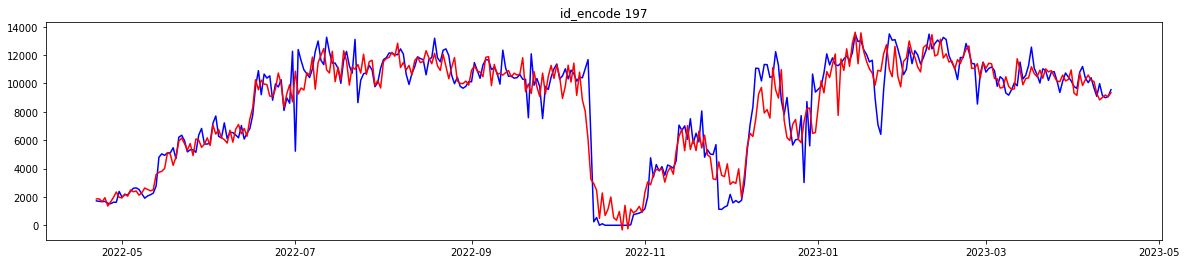

In [368]:
cid = 197
fig = plt.figure(figsize=(20, 4))
df_tmp = df_train_pred[(df_train_pred['id_encode']==cid)]
plt.plot(df_tmp['time'], df_tmp['label'],c='b')
plt.title(f'id_encode {cid}')
plt.plot(df_tmp['time'],df_tmp['pred'],c='r');

9it [00:00, 721.73it/s]


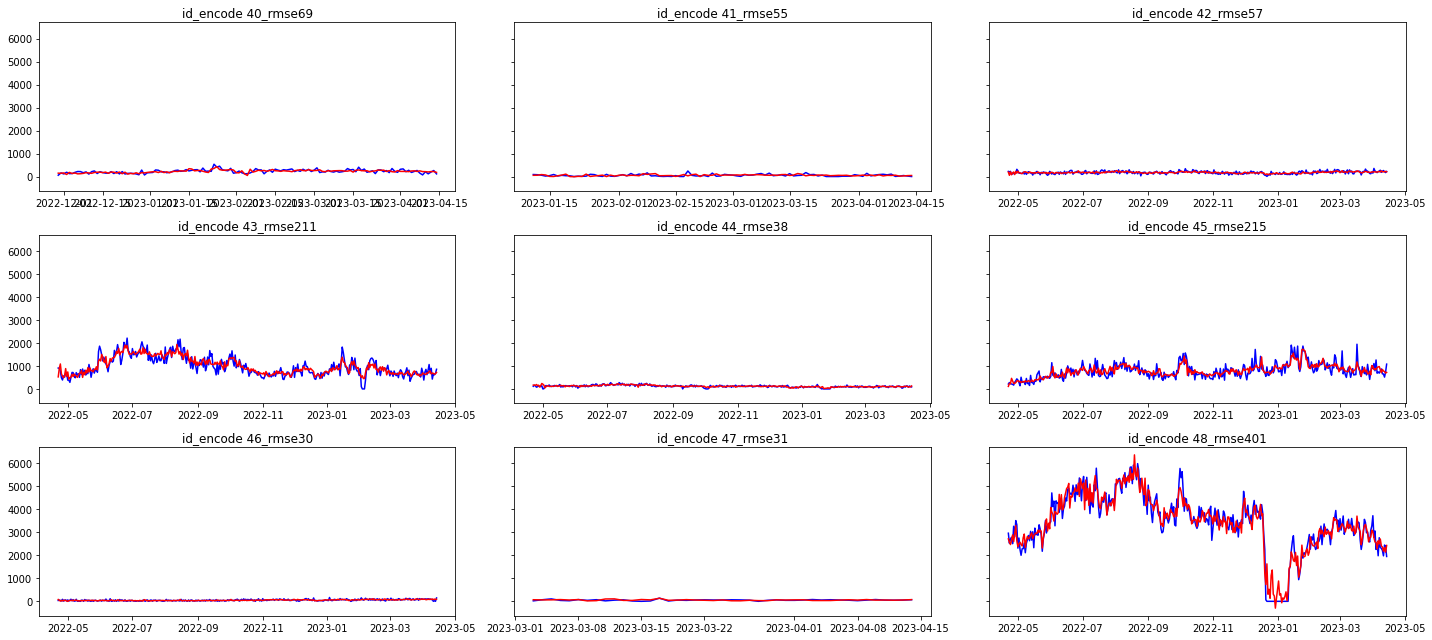

In [378]:
def plot_sub_df(cids, df, pred_flag=0):
    col_num = 3
    fig, axes = plt.subplots(3, col_num, figsize=(20, 9), sharey=True)
    for i,cid in tqdm(enumerate(cids)):
        ax = axes[i // col_num, i % col_num]
        df_tmp = df[(df['id_encode']==cid)]
        ax.plot(df_tmp['time'], df_tmp['power_sum'],c='b')
        rmse = int(df_oof_rmse[cid])
        ax.set_title(f'id_encode {cid}_rmse{rmse}')
        if pred_flag == 1:
            ax.plot(df_tmp['time'],df_tmp['pred'],c='r')
    plt.tight_layout()
cids = np.arange(9) + 40
plot_sub_df(cids, df_train_pred, pred_flag=1)

## 提交

In [379]:
# df_test['pred'] = model_all.predict(df_test[feats])
# df_sub = df_test[['id_encode','ds','pred']]
# df_sub['ds'] = df_sub['ds'].astype(int)
# df_sub.columns = ['id_encode','ds','power']

# save_path = f'../data/output/oofrmse{oof_score}_allpred.csv'
# df_sub.to_csv(save_path,index=False)
# print(f'save sub {save_path}')

In [61]:
df_test = lgbmodel.predict(df_test)

df_sub = df_test[['id_encode','ds','pred']]
df_sub['ds'] = df_sub['ds'].astype(int)
df_sub.columns = ['id_encode','ds','power']

save_path = f'../data/output/{current_time_str}_oofrmse{oof_score}.csv'
df_sub.to_csv(save_path,index=False)
print(f'save sub {save_path}')
df_sub

INFO:regression_lgbmodel:lgb输入数据大小: (3500, 44)


INFO:regression_lgbmodel:============模型预测完成============


save sub ../data/output/20231020_1611_oofrmse252.3.csv


,id_encode,ds,power
0,0,20230415,2095.704802
1,0,20230416,2145.289207
2,0,20230417,2140.313997
3,0,20230418,2270.771766
4,0,20230419,2101.873304
...,...,...,...
3495,499,20230417,672.684419
3496,499,20230418,678.440383
3497,499,20230419,668.068380
3498,499,20230420,654.147476


INFO:regression_lgbmodel:lgb输入数据大小: (3500, 39)
INFO:regression_lgbmodel:============模型预测完成============


save sub ../data/output/20231016_0956_oofrmse260.4.csv


,id_encode,ds,power
365,0,20230415,2034.350093
366,0,20230416,2053.170616
367,0,20230417,2109.715062
368,0,20230418,2171.172550
369,0,20230419,2168.993018
...,...,...,...
152539,499,20230417,645.977527
152540,499,20230418,652.704815
152541,499,20230419,663.135704
152542,499,20230420,668.279160


* 为什么 power_std相关特征如此有效，能否挖掘更有意义的特征
* 几个业务特征为什么有效，如何衍生
* 空缺值多的训练数据的处理
* power为0可能是哪些原因导致的(目前看f3对其有影响，但不完全相关)
* id如何编码合适(全局TE会掉分)